In [1]:
%matplotlib notebook

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time

import wolff

# Track calculation errors
np.seterr('raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
def load_data(dat_path):
    dat = scipy.io.loadmat(dat_path)
    dat = dat['exp1_data'][0, 0]
    
    angles = dat[3].T # Angles (index 0 (left) and 1 (right)), cued or not, rotation, correct
    
    dat = dat[0][0, 0] # Index into EEG data
    
    data = dat[3] # Trials by channels by time
    time = np.squeeze(dat[4]) # Time
    
    # Remove bad trials
    bad = np.squeeze(dat[7]) - 1 # Bad trial numbers, adjust for MATLAB indexing
    data = np.delete(data, bad, axis=0)
    
    # Mean center voltage across channels to normalize
    data = data - np.mean(data, 1, keepdims=True)
    
    # Extract memory item angles and rescale
    angles = np.delete(angles, bad, axis=1)
    cued = angles[2] - 1 # Adjust for MATLAB indexing
    angles = angles[:2] * 2
    
    return data, angles, cued, time
    
def cov_mats(data, trl):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    
    trn_dat = data[np.arange(num_trials) != trl, :, :]
    sigma = np.empty((timesteps, num_channels, num_channels))
    for ti in range(timesteps):
        sigma[ti, :, :] = np.linalg.pinv(wolff.covdiag(trn_dat[:, :, ti]))

    return sigma
    
def prepare_sigma(data):
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    sigma = np.empty((num_trials, timesteps, num_channels, num_channels))
    
    cov_mats_part = partial(cov_mats, data)
    
    # Fill sigma in a parallel fashion
    if __name__ == '__main__':
        with multiprocessing.Pool(20) as pool:
            calcs = pool.imap(cov_mats_part, [trl for trl in range(num_trials)])
            for trl in range(num_trials):
                sigma[trl, :, :, :] = next(calcs)
                clear_output(wait=True)
                print("Preparing sigma...")
                print(str(trl+1) + "/" + str(num_trials))
                
    return sigma
                
def wrap(data, theta, sigma, trl):
    import tensorflow as tf

    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    
    tf.config.experimental_run_functions_eagerly(False)
    device = '/GPU:' + str(trl % 4)

    with tf.device(device):
        delta = tf.Variable(tf.zeros([timesteps, num_channels], dtype='float64'))

        @tf.function
        def mahalanobis(u, v, VI):
            # u.shape: timesteps by channels
            # v.shape: channels
            # VI.shape: channels by channels

            # delta.shape: timesteps by channels
            delta = u - v

            # dot(delta, VI).shape: timesteps by channels
            # delta.T.shape: channels by timesteps
            # dot(dot(delta, VI), delta.T).shape: timesteps by timesteps
            return tf.sqrt(tf.linalg.diag_part(tf.matmul(delta @ VI, delta, transpose_b=True)))

        @tf.function
        def parallel(data, m, sigma):
            calc_dist_part = lambda x: mahalanobis(data, x[0], x[1])
            return tf.map_fn(calc_dist_part, 
                             (m, sigma), 
                             dtype=tf.float64, 
                             parallel_iterations=100)
        
        def amps(trl):
            bin_width = np.pi / 6
            angspace = np.arange(-np.pi, np.pi, bin_width)
            cosines = np.expand_dims(np.cos(angspace), (1, 2))
            distances = np.empty((len(angspace), timesteps, timesteps))

            trn_dat = data[np.arange(num_trials) != trl, :, :]
            trn_angle = theta[np.arange(num_trials) != trl]
            for b in range(len(angspace)):
                angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))
                m = np.mean(trn_dat[angle_dists < bin_width, : , :], 0)

                distances[b] = parallel(tf.constant(data[trl].T), tf.constant(m.T), tf.constant(sigma[trl]))

            mean_centred = distances - np.mean(distances, 0)
            return -np.mean(cosines * mean_centred, 0)

        return amps(trl)
    
def parallel_decode(sub, wrap_part, num_trials, timesteps):
    cross_cos_amp = np.empty((num_trials, timesteps, timesteps))
    
    if __name__ == '__main__':
        with multiprocessing.Pool(15) as pool:
            calcs = pool.imap(wrap_part, [trl for trl in range(num_trials)])
            for trl in range(num_trials):
                clear_output(wait=True)
                print("Decoding sub " + str(sub+1))
                print(str(trl+1) + "/" + str(num_trials))
                cross_cos_amp[trl, :, :] = next(calcs)
                
    return cross_cos_amp

In [3]:
def cross_decode(sub, data, angles, sigma=None):
    if __name__ == '__main__' and sigma is None:
        sigma = prepare_sigma(data)
    
    partial_wrap = partial(wrap, data, angles, sigma)
    if __name__ == '__main__':
        return parallel_decode(sub, partial_wrap, data.shape[0], data.shape[2])

In [ ]:
dec_mem_cued = np.empty((15, 575, 575))
dec_mem_uncued = np.empty((15, 575, 575))

for sub in range(15):
    data, angles, cued, time = load_data('wolff/Data/Dynamic_hidden_states_exp1_' + str(sub+1) + '.mat')

    # Cued == 0 means left side was cued, cued == 1 means right side
    ang_cued_left = angles[0, cued==0]
    ang_cued_right = angles[1, cued==1]
    ang_uncued_left = angles[0, cued==1]
    ang_uncued_right = angles[1, cued==0]

    if __name__ == '__main__':
        sigma_left = prepare_sigma(data[cued==0])
        sigma_right = prepare_sigma(data[cued==1])
        
        cued_left = cross_decode(sub, data[cued==0], ang_cued_left, sigma_left)
        cued_right = cross_decode(sub, data[cued==1], ang_cued_right, sigma_right)
        c = np.mean(np.concatenate((cued_left, cued_right)), 0)
        dec_mem_cued[sub, ...] = gaussian_filter((c + c.T) / 2, sigma=8)
        
        np.save('data/exp2/c_cued' + str(sub) + '.npy', c)
        
        uncued_left = cross_decode(sub, data[cued==1], ang_uncued_left, sigma_right)
        uncued_right = cross_decode(sub, data[cued==0], ang_uncued_right, sigma_left)
        c = np.mean(np.concatenate((uncued_left, uncued_right)), 0)
        dec_mem_uncued[sub, ...] = gaussian_filter((c + c.T) / 2, sigma=8)
        
        np.save('data/exp2/c_uncued' + str(sub) + '.npy', c)

Decoding sub 1
54/623


In [6]:
dec_mem_left = np.empty((15, 575, 575))
dec_mem_right = np.empty((15, 575, 575))

for sub in range(15):
    dat = scipy.io.loadmat('wolff/Data/Dynamic_hidden_states_exp1_' + str(sub+1) + '.mat')
    dat = dat['exp1_data'][0, 0]
    
    angles = dat[3].T # Angles (index 0 (cued) and 1 (uncued)) and some other things
    
    dat = dat[0][0, 0] # Index into EEG data
    
    data = dat[3] # Trials by channels by time
    time = np.squeeze(dat[4]) # Time
    
    # Remove bad trials
    bad = np.squeeze(dat[7]) - 1 # Bad trial numbers, adjust for MATLAB indexing
    data = np.delete(data, bad, axis=0)
    
    # Mean center voltage across channels to normalize
    data = data - np.mean(data, 1, keepdims=True)
    
    # Extract memory item angles and rescale
    angles = np.delete(angles[:2], bad, axis=1) * 2
    
    bin_width = np.pi / 6
    angspace = np.arange(-np.pi, np.pi, bin_width)
    
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    
    sigma = np.empty((num_trials, timesteps, num_channels, num_channels))
    
    # Fill sigma in a parallel fashion
    def cov_mats(trl):
        trn_dat = data[np.arange(num_trials) != trl, :, :]
        sigma = np.empty((timesteps, num_channels, num_channels))
        for ti in range(timesteps):
            sigma[ti, :, :] = np.linalg.pinv(wolff.covdiag(trn_dat[:, :, ti]))

        return sigma

    if __name__ == '__main__':
        with multiprocessing.Pool(20) as pool:
            calcs = pool.imap(cov_mats, [trl for trl in range(num_trials)])
            for trl in range(num_trials):
                sigma[trl, :, :, :] = next(calcs)
                clear_output(wait=True)
                print(trl+1)
                
    cosines = np.expand_dims(np.cos(angspace), (1, 2))
    cross_cos_amp = np.empty((num_trials, timesteps, timesteps))
    
    def wrap(theta, trl):
        import tensorflow as tf

        tf.config.experimental_run_functions_eagerly(False)
        device = '/GPU:' + str(trl % 4)

        with tf.device(device):
            delta = tf.Variable(tf.zeros([timesteps, num_channels], dtype='float64'))

            @tf.function
            def mahalanobis(u, v, VI):
                # u.shape: timesteps by channels
                # v.shape: channels
                # VI.shape: channels by channels

                # delta.shape: timesteps by channels
                delta = u - v

                # dot(delta, VI).shape: timesteps by channels
                # delta.T.shape: channels by timesteps
                # dot(dot(delta, VI), delta.T).shape: timesteps by timesteps
                return tf.sqrt(tf.linalg.diag_part(tf.matmul(delta @ VI, delta, transpose_b=True)))

            @tf.function
            def parallel(data, m, sigma):
                calc_dist_part = lambda x: mahalanobis(data, x[0], x[1])
                return tf.map_fn(calc_dist_part, 
                                 (m, sigma), 
                                 dtype=tf.float64, 
                                 parallel_iterations=100)

            def amps(trl):
                distances = np.empty((len(angspace), timesteps, timesteps))

                trn_dat = data[np.arange(num_trials) != trl, :, :]
                trn_angle = theta[np.arange(num_trials) != trl]
                for b in range(len(angspace)):
                    angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))
                    m = np.mean(trn_dat[angle_dists < bin_width, : , :], 0)

                    distances[b] = parallel(tf.constant(data[trl].T), tf.constant(m.T), tf.constant(sigma[trl]))

                mean_centred = distances - np.mean(distances, 0)
                return -np.mean(cosines * mean_centred, 0)

            return amps(trl)
    
    partial_wrap = partial(wrap, angles[0])
    
    if __name__ == '__main__':
        with multiprocessing.Pool(10) as pool:
            calcs = pool.imap(partial_wrap, [trl for trl in range(num_trials)])
            for trl in range(num_trials):
                clear_output(wait=True)
                print(str(trl+1) + "/" + str(num_trials))
                cross_cos_amp[trl, :, :] = next(calcs)
                
    c = np.mean(cross_cos_amp, 0)
    
    dec_mem_left[sub, ...] = gaussian_filter((c + c.T) / 2, sigma=8)
    
    partial_wrap = partial(wrap, angles[1])
    
    if __name__ == '__main__':
        with multiprocessing.Pool(10) as pool:
            calcs = pool.imap(partial_wrap, [trl for trl in range(num_trials)])
            for trl in range(num_trials):
                clear_output(wait=True)
                print(str(trl+1) + "/" + str(num_trials))
                cross_cos_amp[trl, :, :] = next(calcs)
                
    c = np.mean(cross_cos_amp, 0)
    
    dec_mem_right[sub, ...] = gaussian_filter((c + c.T) / 2, sigma=8)

1299/1299


<IPython.core.display.Javascript object>


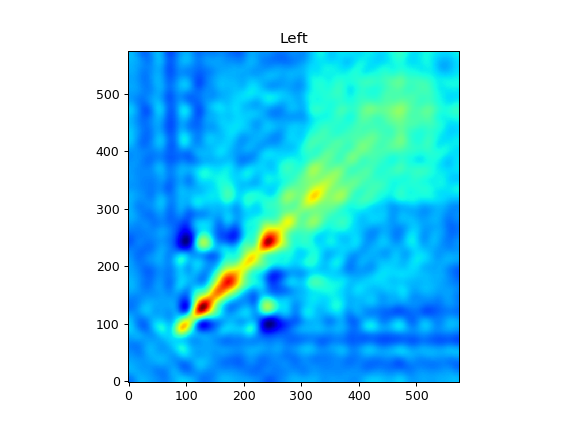

In [7]:
plt.close()

plt.title('Left')
plt.imshow(np.mean(dec_mem_left, 0), cmap='jet', origin='lower')

<IPython.core.display.Javascript object>


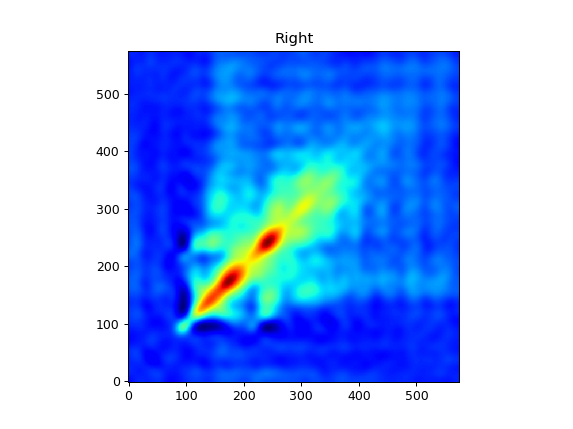

In [8]:
plt.close()

plt.title('Right')
plt.imshow(np.mean(dec_mem_right, 0), cmap='jet', origin='lower')